In [0]:
# importing the libraries
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import os
import scipy.io
import math

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
IMG_SIZE = 30
NUM_IMAGES = 2000

image_path = '/content/gdrive/My Drive/Colab Notebooks/Vernacular/clothing/stanford/images/'
label_path = '/content/gdrive/My Drive/Colab Notebooks/Vernacular/clothing/stanford/labels/'


In [0]:
loaded_images = []

file_num = lambda x: (int(x.split('.')[0]) - 1)

files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]
files = sorted(files, key=file_num)
files = files[:NUM_IMAGES]

for i, file in enumerate(files):
  loaded_images.append(cv2.imread(os.path.join(image_path, file)))
  if i%25==24:
    print("Loading Image: %s"%file)

Loading Image: 000025.jpg
Loading Image: 000050.jpg
Loading Image: 000075.jpg
Loading Image: 000100.jpg
Loading Image: 000125.jpg
Loading Image: 000150.jpg
Loading Image: 000175.jpg
Loading Image: 000200.jpg
Loading Image: 000225.jpg
Loading Image: 000250.jpg
Loading Image: 000275.jpg
Loading Image: 000300.jpg
Loading Image: 000325.jpg
Loading Image: 000350.jpg
Loading Image: 000375.jpg
Loading Image: 000400.jpg
Loading Image: 000425.jpg
Loading Image: 000450.jpg
Loading Image: 000475.jpg
Loading Image: 000500.jpg
Loading Image: 000525.jpg
Loading Image: 000550.jpg
Loading Image: 000575.jpg
Loading Image: 000600.jpg
Loading Image: 000625.jpg
Loading Image: 000650.jpg
Loading Image: 000675.jpg
Loading Image: 000700.jpg
Loading Image: 000725.jpg
Loading Image: 000750.jpg
Loading Image: 000775.jpg
Loading Image: 000800.jpg
Loading Image: 000825.jpg
Loading Image: 000850.jpg
Loading Image: 000875.jpg
Loading Image: 000900.jpg
Loading Image: 000925.jpg
Loading Image: 000950.jpg
Loading Imag

In [0]:
labels = scipy.io.loadmat(os.path.join(label_path, 'category_GT.mat'))
labels = labels['GT']
NUM_OUTPUTS = int(len(np.unique(list(filter(lambda x: not math.isnan(x), [label[0] for label in labels])))))

In [0]:
X = []
Y = []
for i, image in enumerate(loaded_images):
  label = labels[i][0]
  if math.isnan(label):
    continue
  img = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
  img = img.astype('float32')
  img = img / 255.0
  X.append(img)
  Y.append(label)

X = np.asarray(X)
Y = np.asarray(Y)
X.shape, Y.shape

((1104, 64, 64, 3), (1104,))

In [0]:
# from google.colab.patches import cv2_imshow
# cv2_imshow(X[1])

In [0]:
trainX, test_x, trainY, test_y = train_test_split(X, Y, test_size = 0.1)
train_x, val_x, train_y, val_y = train_test_split(trainX, trainY, test_size = 0.2)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

# train_x = train_x.reshape(train_x.shape[0], train_x.shape[3], IMG_SIZE, IMG_SIZE)
train_x  = torch.from_numpy(train_x)
train_x = train_x.permute(0,3,1,2)
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# val_x = val_x.reshape(val_x.shape[0], val_x.shape[3], IMG_SIZE, IMG_SIZE)
val_x  = torch.from_numpy(val_x)
val_x = val_x.permute(0,3,1,2)
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)
train_x.shape, train_y.shape, val_x.shape, val_y.shape

# test_x = test_x.reshape(test_x.shape[0], test_x.shape[3], IMG_SIZE, IMG_SIZE)
test_x  = torch.from_numpy(test_x)
test_x = test_x.permute(0,3,1,2)
test_y = test_y.astype(int);
test_y = torch.from_numpy(test_y)
train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape

(torch.Size([794, 3, 64, 64]),
 torch.Size([794]),
 torch.Size([199, 3, 64, 64]),
 torch.Size([199]),
 torch.Size([111, 3, 64, 64]),
 torch.Size([111]))

In [0]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(int(IMG_SIZE * IMG_SIZE / 4), NUM_OUTPUTS)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        # x = x.view(x.size(0), -1)
        x = x.reshape(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [0]:
model = Net()
optimizer = Adam(model.parameters(), lr=0.07)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1024, out_features=7, bias=True)
  )
)


In [0]:
if torch.cuda.is_available:
  print("Using CUDA")

Using CUDA


In [0]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    X_train, Y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    X_val, Y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        X_train = X_train.cuda()
        Y_train = Y_train.cuda()
        X_val = X_val.cuda()
        Y_val = Y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(X_train)
    output_val = model(X_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, Y_train)
    loss_val = criterion(output_val, Y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [0]:
n_epochs = 40
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(1.9487, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(41.9701, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(28.1450, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(11.7662, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(3.5279, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(2.0183, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(1.9270, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(1.9085, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  17 	 loss : tensor(1.8893, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  19 	 loss : tensor(1.8713, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  21 	 loss : tensor(1.8555, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  23 	 loss : tensor(1.8425, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  25 	 loss : tensor(1.8323, device

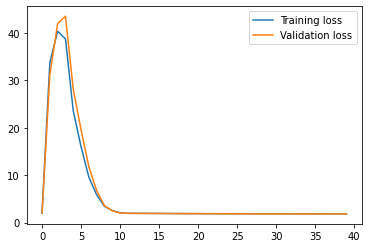

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [0]:
# prediction for training set
with torch.no_grad():
  if(torch.cuda.is_available):
    output = model(train_x.cuda())
  else:
    output = model(train_x)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
train_sample_accuracy = accuracy_score(train_y, predictions)
print("Accuracy on In-Sample Training Set: %s"% train_sample_accuracy)

Accuracy on In-Sample Training Set: 0.0


In [0]:
# prediction for validation set
with torch.no_grad():
  if(torch.cuda.is_available):
    output = model(val_x.cuda())
  else:
    output = model(val_x)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
val_sample_accuracy = accuracy_score(val_y, predictions)
print("Accuracy on In-Sample Validation Set: %s"% val_sample_accuracy)


Accuracy on In-Sample Validation Set: 0.0


In [0]:
# prediction for out-of-sample set
with torch.no_grad():
  if(torch.cuda.is_available):
    output = model(test_x.cuda())
  else:
    output = model(test_x)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on out-of-sample set
out_sample_accuracy = accuracy_score(test_y, predictions)
print("Accuracy on Out-Of-Sample Validation (Test) Set: %s"% out_sample_accuracy)

Accuracy on Out-Of-Sample Validation (Test) Set: 0.0
